<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fgeneration/applications/generation/Machine%20Translation%20with%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import random
import math
import spacy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [0]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
!python -m spacy download de

     |████████████████████████████████| 14.9MB 108kB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=d1c457cdb4d5013068031e0e977a2915de3e46b67ff7e12815c1fc4854ed6a8e
  Stored in directory: /tmp/pip-ephem-wheel-cache-br5sqqmw/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [0]:
spacy_en = spacy.load('en')
spacy_de = spacy.load('de')

In [0]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [0]:
SRC = Field(
    tokenize=tokenize_de,
    lower=True,
    init_token='<sos>',
    eos_token='<eos>',
    batch_first=True
)

TRG = Field(
    tokenize=tokenize_en,
    lower=True,
    init_token='<sos>',
    eos_token='<eos>',
    batch_first=True
)

In [8]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))

training.tar.gz:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 3.89MB/s]
validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.39MB/s]

downloading validation.tar.gz
downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.37MB/s]


In [0]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
BATCH_SIZE = 64

In [0]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device
)

In [0]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout, device):
        super().__init__()

        assert d_model % n_heads == 0, "n_heads must be a factor of d_model"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        self.fc = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask=None):
        # query => [batch_size, seq_len, d_model] 
        # key => [batch_size, seq_len, d_model]
        # value => [batch_size, seq_len, d_model]

        batch_size = query.shape[0]

        Q = self.q(query)
        K = self.k(key)
        V = self.v(value)
        # Q, K, V => [batch_size, seq_len, d_model]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q, K, V => [batch_size, n_heads, seq_len, head_dim]

        energy = torch.matmul(Q, K.permute(0 ,1, 3, 2))
        energy = energy / self.scale
        # energy => [batch_size, n_heads, query_len, key_len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim=-1)
        # attention => [batch_size, n_heads, query_len, key_len]

        weighted = torch.matmul(attention, V)
        # weighted => [batch_size, n_heads, query_len, head_dim]

        weighted = weighted.permute(0, 2, 1, 3).contiguous()
        # weighted => [batch_size, query_len, n_heads, head_dim]

        x = weighted.view(batch_size, -1, self.d_model)
        # x => [batch_size, query_len, d_model]

        x = self.fc(x)
        # x => [batch_size, query_len, d_model]
        # attention => [batch_size, n_heads, query_len, key_len]

        return x, attention


In [0]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, pff_dim, dropout):
        super().__init__()

        self.fc1 = nn.Linear(d_model, pff_dim)
        self.fc2 = nn.Linear(pff_dim, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        # input => [batch_size, seq_len, d_model]

        x = self.dropout(torch.relu(self.fc1(input)))
        # x => [batch_size, seq_len, pff_dim]

        x = self.fc2(x)
        # x => [batch_size, seq_len, d_model]

        return x


In [0]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, pff_dim, dropout, device):
        super().__init__()

        self.self_attention = SelfAttention(d_model, n_heads, dropout, device)
        self.pff = PositionWiseFeedForward(d_model, pff_dim, dropout)

        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.pff_layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # src => [batch_size, src_len, d_model]

        # self attention on src
        _src, _ = self.self_attention(src, src, src, src_mask)
        # _src => [batch_size, src_len, d_model]

        # residual connection and layer normalization
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        # src => [batch_size, src_len, d_model]

        # position wise feed forward
        _src = self.pff(src)
        # _src => [batch_size, src_len, d_model]

        # residual connection and layer normalization
        src = self.pff_layer_norm(src + self.dropout(_src))
        # src => [batch_size, src_len, d_model]

        return src

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_layers, n_heads, pff_dim, dropout, device, max_len=500):
        super().__init__()

        self.n_layers = n_layers
        self.device = device
        self.word_embedding = nn.Embedding(input_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, pff_dim, dropout, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)
    
    def forward(self, src, src_mask):
        # src => [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos => [batch_size, src_len]

        word_embed = self.word_embedding(src)
        word_embed = word_embed * self.scale
        # word_embed => [batch_size, src_len, d_model]

        pos_embed = self.pos_embedding(pos)
        # pos_embed => [batch_size, src_len, d_model]

        src = self.dropout(word_embed + pos_embed)
        # src => [batch_size, src_len, d_model]

        for layer in self.layers:
            src = layer(src, src_mask)
        
        # src => [batch_size, src_len, d_model]
        return src


In [0]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, pff_dim, dropout, device):
        super().__init__()

        self.self_attention = SelfAttention(d_model, n_heads, dropout, device)
        self.enc_attention = SelfAttention(d_model, n_heads, dropout, device)
        self.pff = PositionWiseFeedForward(d_model, pff_dim, dropout)

        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.enc_attn_layer_norm = nn.LayerNorm(d_model)
        self.pff_layer_norm = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        # _trg => [batch_size, trg_len, d_model]

        # residual connection and layer normalization
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        # trg => [batch_size, trg_len, d_model]

        # enc_attention
        _trg, attention = self.enc_attention(trg, enc_src, enc_src, src_mask)
        # _trg => [batch_size, trg_len, d_model]
        # attention => [batch_size, n_heads, trg_len, src_len]

        # residual connection and layer normalization
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        # trg => [batch_size, trg_len, d_model]

        # positionwise feed forward
        _trg = self.pff(trg)
        # _trg => [batch_size, trg_len, d_model]

        # residual connection and layer normalization
        trg = self.pff_layer_norm(trg + self.dropout(_trg))
        # trg => [batch_size, trg_len, d_model]

        return trg, attention


In [0]:
class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_layers, n_heads, pff_dim, dropout, device, max_len=500):
        super().__init__()
        
        self.device = device
        self.word_embedding = nn.Embedding(output_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, pff_dim, dropout, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)

        self.fc_out = nn.Linear(d_model, output_dim)
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)
    
    def forward(self, trg, enc_src, trg_mask, src_mask):

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos => [batch_size, trg_len]

        word_embedding = self.word_embedding(trg)
        word_embedding = word_embedding * self.scale
        # word_embedding => [batch_size, trg_len, d_model]

        pos_embedding = self.pos_embedding(pos)
        # pos_embedding => [batch_size, trg_len, d_model]

        trg = self.dropout(word_embedding + pos_embedding)
        # trg => [batch_size, trg_len, d_model]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        logits = self.fc_out(trg)
        # logits => [batch_size, trg_len, output_dim]
        # attention => [batch_size, n_heads, trg_len, src_len]

        return logits, attention


In [0]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2).to(self.device)
        # src_mask => [batch_size, 1, 1, src_len]
        
        return src_mask
    
    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2).to(self.device)
        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        trg_mask = trg_pad_mask & trg_sub_mask
        # trg_mask => [batch_size, 1, trg_len, trg_len]

        return trg_mask
 
    def forward(self, src, trg):
        # src => [batch_size, src_len]
        # trg => [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        return output, attention

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [0]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [22]:
def init_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(init_weights)

Transformer(
  (encoder): Encoder(
    (word_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attention): SelfAttention(
          (q): Linear(in_features=256, out_features=256, bias=True)
          (k): Linear(in_features=256, out_features=256, bias=True)
          (v): Linear(in_features=256, out_features=256, bias=True)
          (fc): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (pff): PositionWiseFeedForward(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (pff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,243,653 trainable parameters


In [0]:

LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [0]:
def train(model, iterator, criterion, optimizer, clip):
    model.train()

    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output, _ = model(src, trg[:, :-1])
        # output => [batch_size, trg_len - 1, output_dim]
        # trg => [batch_size, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)


In [0]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:, :-1])
            # output => [batch_size, trg_len - 1, output_dim]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins * 60)
    return elapsed_mins, elapsed_secs

In [28]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, train_iterator, criterion, optimizer, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss): 7.3f}")
    print(f"\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss): 7.3f}")

Epoch: 01 | Time: 0m 20.480451822280884s
	Train Loss: 3.816 | Train PPL:  45.417
	Valid Loss: 2.734 | Valid PPL:  15.389
Epoch: 02 | Time: 0m 20.005929946899414s
	Train Loss: 2.522 | Train PPL:  12.452
	Valid Loss: 2.088 | Valid PPL:   8.072
Epoch: 03 | Time: 0m 19.959733486175537s
	Train Loss: 1.985 | Train PPL:   7.276
	Valid Loss: 1.816 | Valid PPL:   6.146
Epoch: 04 | Time: 0m 19.894444227218628s
	Train Loss: 1.663 | Train PPL:   5.273
	Valid Loss: 1.711 | Valid PPL:   5.535
Epoch: 05 | Time: 0m 19.919212341308594s
	Train Loss: 1.431 | Train PPL:   4.182
	Valid Loss: 1.637 | Valid PPL:   5.142
Epoch: 06 | Time: 0m 19.91314935684204s
	Train Loss: 1.253 | Train PPL:   3.501
	Valid Loss: 1.600 | Valid PPL:   4.953
Epoch: 07 | Time: 0m 19.936415195465088s
	Train Loss: 1.108 | Train PPL:   3.028
	Valid Loss: 1.627 | Valid PPL:   5.090
Epoch: 08 | Time: 0m 19.90435814857483s
	Train Loss: 0.990 | Train PPL:   2.692
	Valid Loss: 1.629 | Valid PPL:   5.101
Epoch: 09 | Time: 0m 19.7570977210

In [29]:
model.load_state_dict(torch.load('model.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f"\tTest Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss): 7.3f}")

	Test Loss: 1.663 | Test PPL:   5.273


In [0]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()

    if isinstance(sentence, str):
        tokens = tokenize_de(sentence)
        tokens = [token.lower() for token in tokens]
    else:
        tokens = [token.lower() for token in sentence]
    
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_ids = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(device)

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    
    trg_ids = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_ids).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:, -1].item()

        trg_ids.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_ids]

    return trg_tokens[1:], attention


In [0]:
def display_attention(sentence, translation, attention, n_heads=8, n_rows=2, n_cols=4):
    
    fig = plt.figure(figsize=(25, 12))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='Blues')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)
        title = f"Attention Head: {i+1}"
        ax.set_xlabel(title)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']
predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'past', 'a', 'gate', '.', '<eos>']


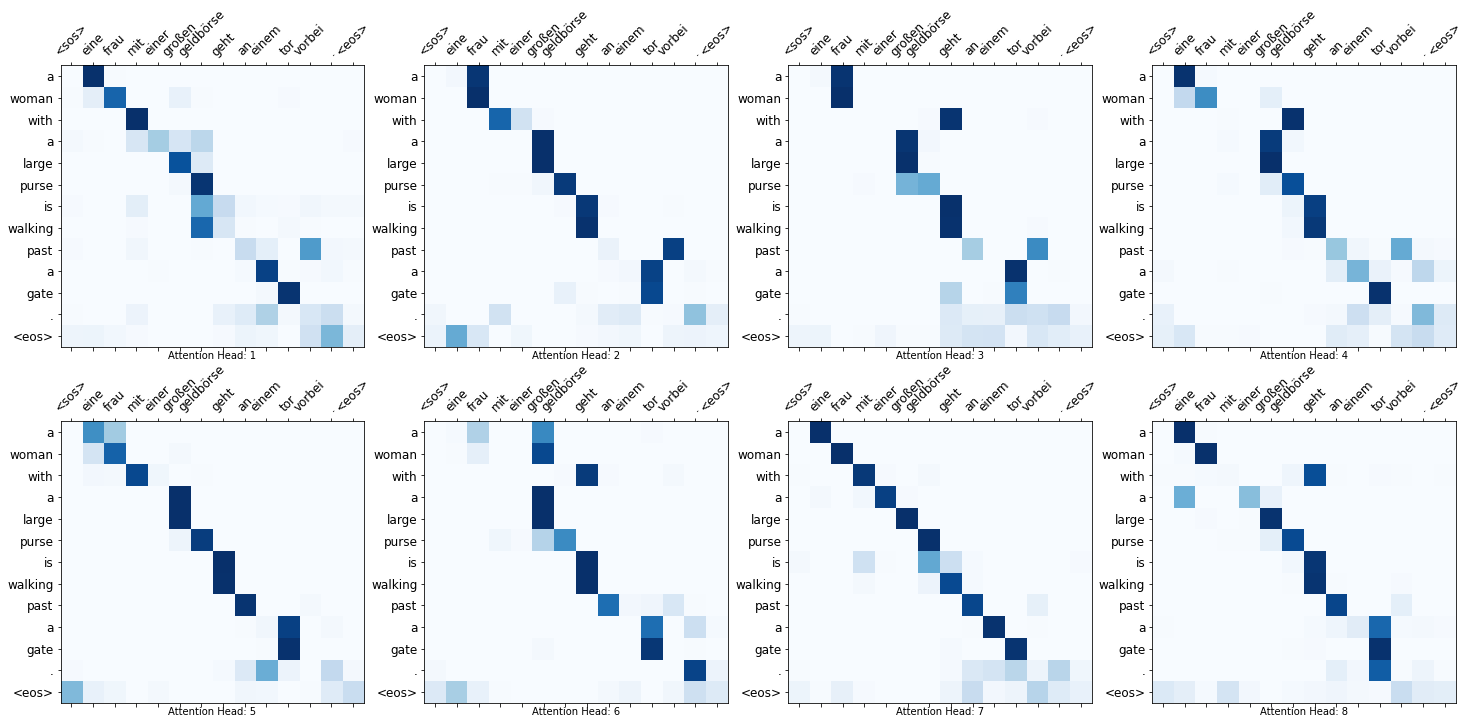

In [73]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')


translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)